In [38]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_columns', 10)
pd.set_option('display.precision', 4)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>div.container { width:100% !important; }</style>"))
display(HTML("<style>div.cell { width:65% !important; margin: auto; }</style>"))
display(HTML("<style>div.output_png { background-color: white; position: relative; width: 400% !important; left: -35%; overflow-x: visible !important; }</style>"))
display(HTML("<style>div.output_png img { max-width: 1900px !important; margin: auto !important; }</style>"))

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Convex combination of two adaptive filters

### load and prepare data

In [117]:

BATCH_ID = '1608230127'

import yaml
import glob
import os.path

DATASETS_DIR = os.path.join('..', '..', 'datasets', 'results')
with open(glob.glob(os.path.join(DATASETS_DIR, '%s*.yaml' % BATCH_ID))[0], 'r') as ifile:
    BATCH_SPECS = yaml.safe_load(ifile)

ATTACK = BATCH_SPECS['default_parameters']['attack']['parameters']
if 'duration' not in ATTACK:
    ATTACK.update({'duration': ATTACK['end'] - ATTACK['start']})

ifilepath = os.path.join(DATASETS_DIR, '%s-df.dat' % BATCH_ID)
DF = pd.read_pickle(ifilepath)

TOTAL_TIMESTEPS = len(list(filter(lambda label: label.name == 'timestep', DF.columns.levels))[0])

DF

metrics                                                              cost                                   ...         λ                                
timestep                                                            0       1       2       3       4       ...     32697   32698   32699   32700   32701
classifier fast     classifier slow     η fast η slow experiment_id                                         ...                                          
adaline             adaline             0.010  0.0010 1608230127 0    1.0  0.9966  0.9907  0.9890  0.9831   ...    0.1500  0.1500  0.1500  0.1500  0.1500
                                               0.0005 1608230127 1    1.0  0.9965  0.9960  0.9937  0.9934   ...    0.1500  0.1500  0.1500  0.1500  0.1500
                                        0.005  0.0010 1608230127 2    1.0  0.9966  0.9962  0.9963  0.9963   ...    0.1500  0.1500  0.1500  0.1500  0.1500
                                               0.0005 1608230127 3    1.0  0.9902  0.9902  0.9898  0.9902   ...    0.8493  0.8496  0.8499  0.8499  0.8499
                    logistic regression 0.010  0.0010 1608230127 4    1.0  0.9974  0.9954  0.9945  0.9766   ...    0.1502  0.1502  0.1502  0.1502  0.1502
                                               0.0005 1608230127 5    1.0  0.9874  0.9643  0.9596  0.9608   ...    0.1500  0.1500  0.1500  0.1500  0.1500
                                        0.005  0.0010 1608230127 6    1.0  0.9988  0.9939  0.9907  0.9880   ...    0.1500  0.1500  0.1500  0.1500  0.1500
                                               0.0005 1608230127 7    1.0  0.9846  0.9811  0.9808  0.9815   ...    0.1502  0.1502  0.1502  0.1502  0.1502
logistic regression adaline             0.010  0.0010 1608230127 8    1.0  0.9924  0.9914  0.9892  0.9817   ...    0.8500  0.8500  0.8500  0.8500  0.8500
                                               0.0005 1608230127 9    1.0  0.9982  0.9982  0.9981  0.9964   ...    0.8500  0.8500  0.8500  0.8500  0.8500
                                        0.005  0.0010 1608230127 10   1.0  0.9996  0.9994  0.9905  0.9884   ...    0.8500  0.8500  0.8500  0.8500  0.8500
                                               0.0005 1608230127 11   1.0  0.9982  0.9981  0.9966  0.9971   ...    0.8500  0.8500  0.8500  0.8500  0.8500
                    logistic regression 0.010  0.0010 1608230127 12   1.0  0.9981  1.0015  1.0005  1.0005   ...    0.8500  0.8500  0.8500  0.8500  0.8500
                                               0.0005 1608230127 13   1.0  0.9842  0.9819  0.9803  0.9797   ...    0.8500  0.8500  0.8500  0.8500  0.8500
                                        0.005  0.0010 1608230127 14   1.0  1.0011  1.0002  0.9985  0.9930   ...    0.8500  0.8500  0.8500  0.8500  0.8500
                                               0.0005 1608230127 15   1.0  1.0022  1.0018  1.0004  1.0004   ...    0.8500  0.8500  0.8500  0.8500  0.8500

[16 rows x 228914 columns]

In [100]:

def chunks(lst, groups_of):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(lst), groups_of):
        yield lst[i:i + groups_of]

def get_df(experiment_id):
    return DF.xs(experiment_id, level='experiment_id')

def shorten(name):
    if type(name) == str:
        name = 'LogReg' if name == 'logistic regression' else name.capitalize()
    return name
    
def latexify(name):
    name = '%s_{%s}' % tuple(name.split(' '))
    return name

def get_title(df):
    idx = df.index
    levels = ('$%s: %s$' % (latexify(name), shorten(level[label][0]))
              for name, level, label in zip(idx.names, idx.levels, idx.labels))
    return '\n'.join(levels)

def prepare(df):
    return df.stack('timestep').reset_index(df.index.names, drop=True)

from copy import deepcopy
PARAMS = {
    'sharex': True,
    'ylim': (0, 1),
    'legend': None,
}


def visualise(df, axes, idx=0, title='', **custom_params):
    '''visualise 1 experiment'''

    columns = [['cost1', 'cost2', 'cost'], ['error1', 'error2', 'error'], ['λ']]
    labels  = [['cost_{fast}', 'cost_{slow}', 'cost_{combination}'],
               ['error_{fast}', 'error_{slow}', 'error_{combination}'], ['λ']]

    for ii, (metric, label) in enumerate(zip(columns, labels)):

        axis = plt.subplot(axes[ii, idx])
        axis.add_patch(patches.Rectangle((ATTACK['start'], 0), ATTACK['duration'], 1,
                                         facecolor='gray', edgecolor='none', alpha=0.1))
        params = {**deepcopy(PARAMS), **custom_params}
        if ii == 2:
            params.update({'color': 'black'})
        df.plot(x=df.index, y=metric, ax=axis, **params)

        axis.set_yticklabels([])
        if idx == 0:
            axis.set_yticklabels([''] + list(np.arange(0.2, 1.2, 0.2)),
                                 position=(-0.01, 0), verticalalignment='top')

        if idx == axes._ncols-1:
            axis.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5),
                        labels=['$%s$' % l for l in label], fontsize=14)
            if ii == 2:
                plt.yticks([0.15, 0.85], ['slow', 'fast'])
                axis.yaxis.set_ticks_position('right')
                for tick, color in zip(axis.yaxis.get_ticklabels(), ['green', 'blue']):
                    tick.set_color(color)

        if ii == 0:
            plt.title(title, fontsize=16, y=1.1)

    for label in axis.xaxis.get_ticklabels()[1::2]: label.set_visible(False)

    return


def compare(dfs, figsize=(27, 7), **kwargs):
    '''visualise multiple experiment'''
    fig = plt.figure(figsize=figsize)
    axes = gridspec.GridSpec(3, len(dfs), height_ratios=[2, 2, 1])
    axes.update(hspace=0, wspace=0.05)

    for idx, (df, title) in enumerate(dfs):
        visualise(df, axes, idx, title, **kwargs)

    plt.show()
    return


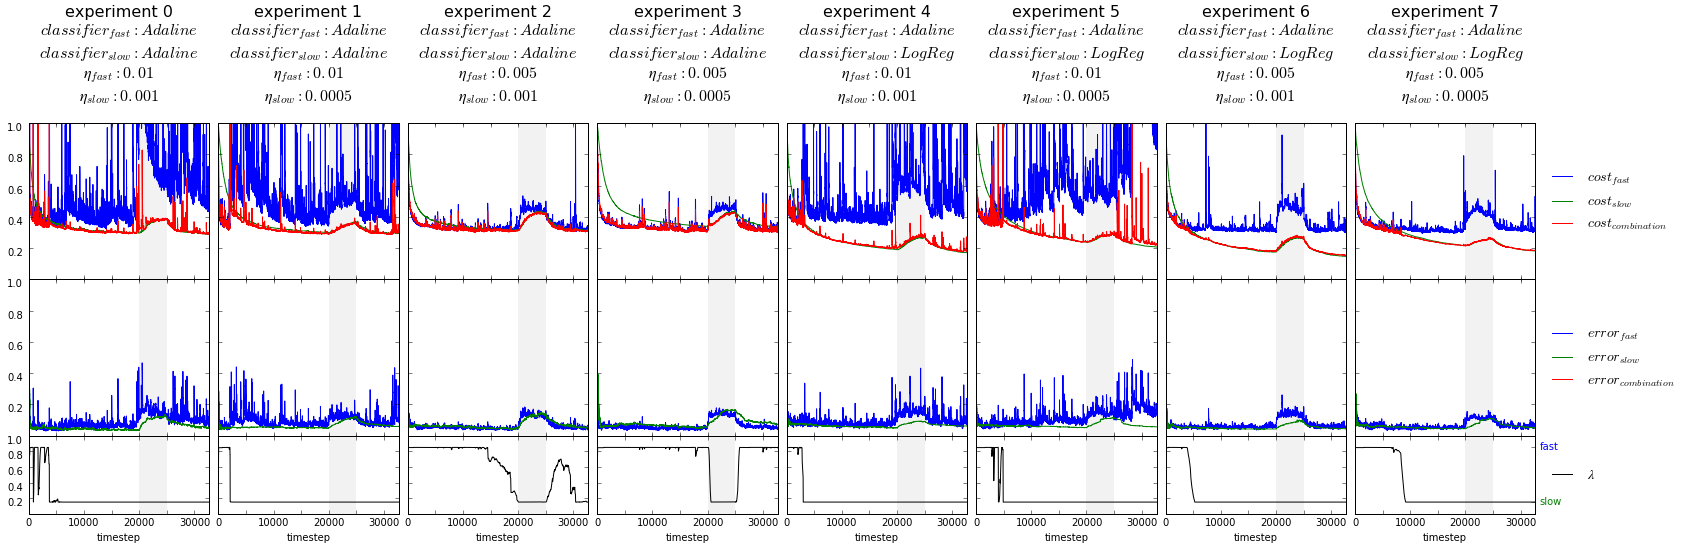

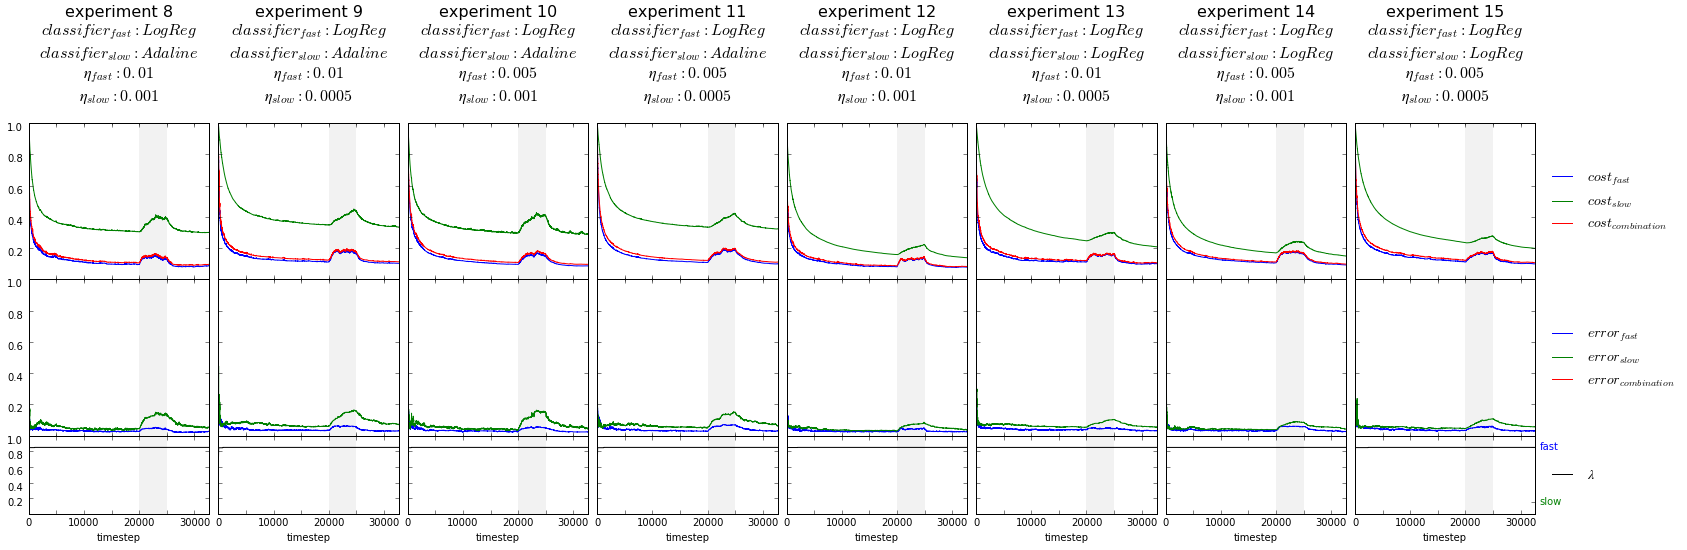

In [101]:

experiment_ids = sorted(DF.index.levels[-1], key=lambda label: int(label.split(' ')[1]))

for experiment_ids_group in chunks(experiment_ids, groups_of=8):

    dfs = list(map(get_df, experiment_ids_group))
    titles = map(lambda expid_df: 'experiment %s\n%s' % (expid_df[0].split(' ')[1], get_title(expid_df[1])),
                 zip(experiment_ids_group, dfs))
    dfs = map(prepare, dfs)

    compare(list(zip(dfs, titles)))

## Observations and early interpretation

- Adaline cost falls faster than LogReg, but LogReg cost goes lower

- the 'timescale' isn't long enough at ~30000, with these learning rates, for LogReg to reach steady state (at least the classifier with the slower learning rate)


- as seen in the offline experiments, the adaline classifier is more unstable than the logistic regression classifier, for the same learning rate (or in general ?). Unstable is defined as, it oscillates more / is more noisy.

- it's interesting, we saw from the offline experiments that Adaline costs would just diverge and explode, but here it seems that it comes back down. What makes it come back even though it has gone up so much ?

- 0.01 (as set for fast version) for the Adaline classifier is too unstable


- the combination cost is still unstable when the fast classifier is Adaline, despite "following" the slow classifier. This is probably due to the mixing parameter including a minimum threshold of both classifiers (here 0.15% of the fast)

- **experiment 2** is interesting, because a few noisy emails a bit before 30000 are enough to make the mixing parameter doubt its transition and go back to slow. This could be because slow and fast already have the same cost, so which one to choose ?

### Closer look at experiment 2

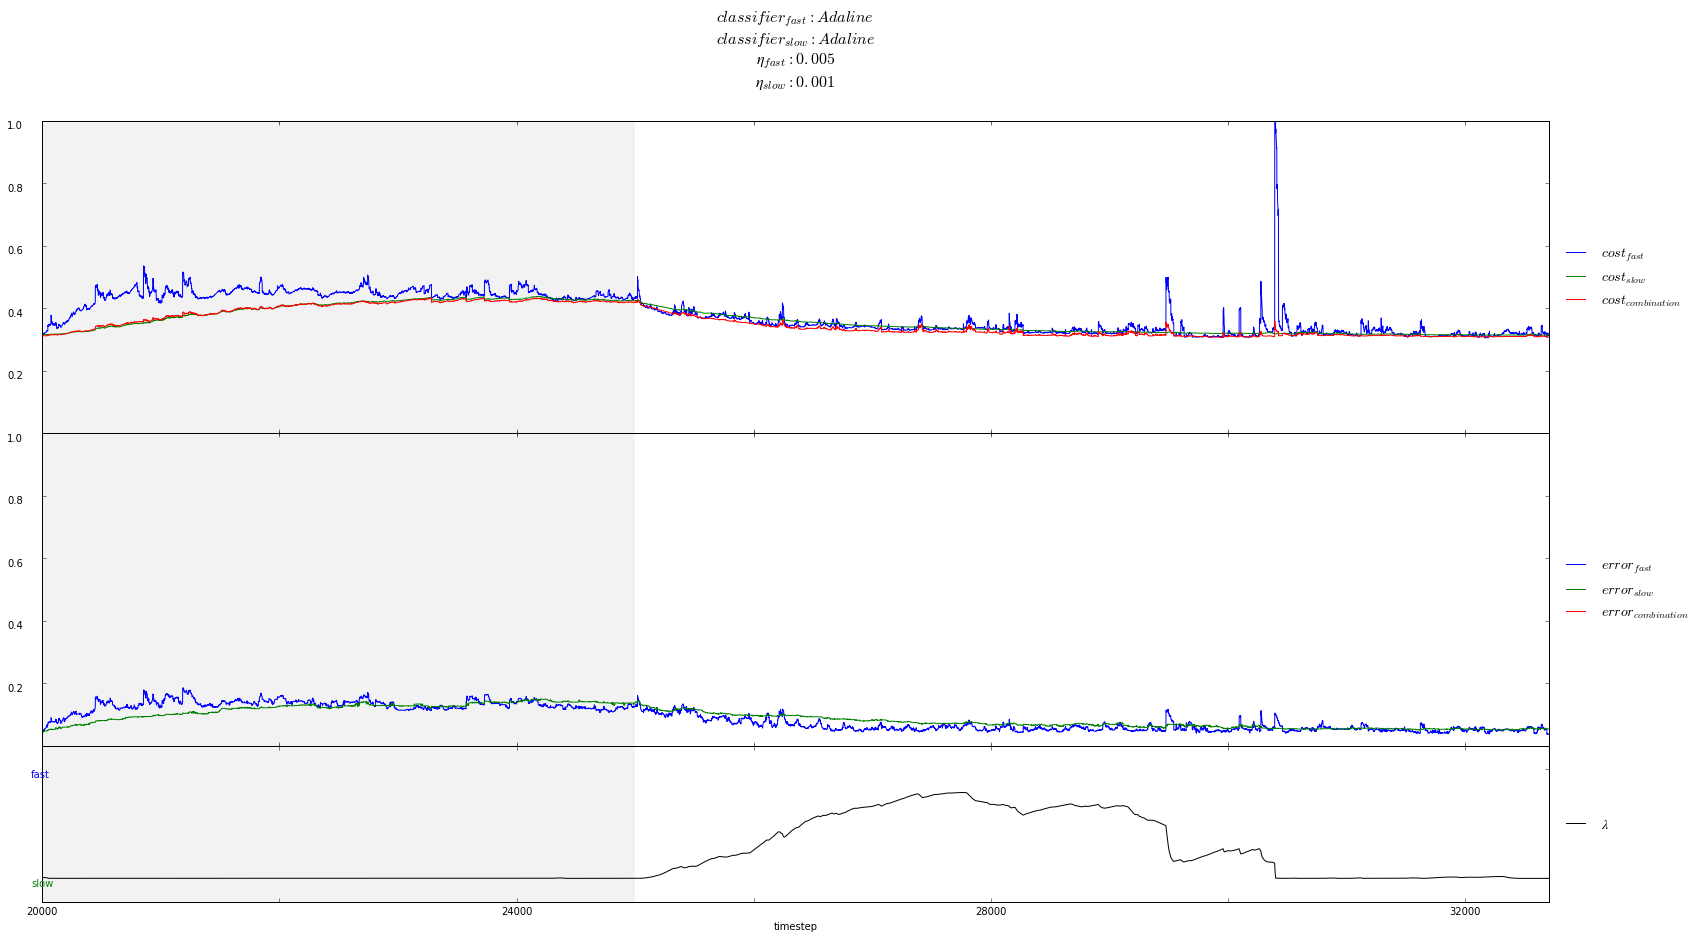

In [119]:
experiment_id = '%s %s' % (BATCH_ID, 2)
df = get_df(experiment_id)
custom_params = {'xlim': (20000, TOTAL_TIMESTEPS)}
compare([(prepare(df), get_title(df))], figsize=(27, 14), **custom_params)

### Compare Logistic Regression costs with different learning rates

In [160]:
def compare_learning_rates(classifier_type):
    df_plot = DF.ix[classifier_type, classifier_type][['cost1', 'cost2']]
    learning_rates = [('η fast', 0.01,   'cost1'),
                      ('η fast', 0.005,  'cost1'),
                      ('η slow', 0.001,  'cost2'),
                      ('η slow', 0.0005, 'cost2'),]

    fig = plt.figure(figsize=(26, 14))
    for level, rate, col in learning_rates:
        df = df_plot.xs(rate, level=level)[col].mean()
        df.plot(label=rate, ylim=(0,1))
    plt.legend()
    plt.show()
    return

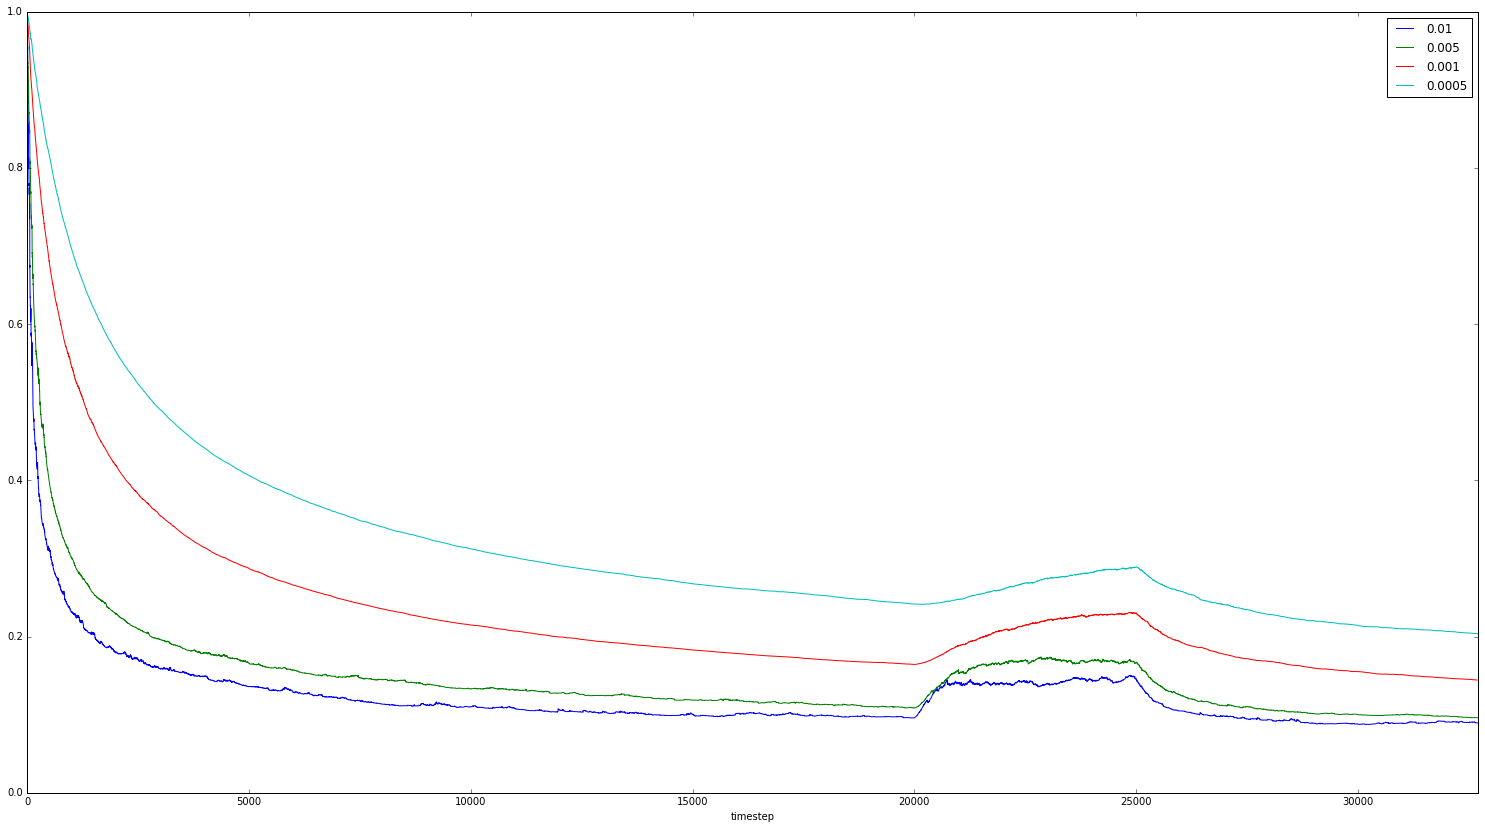

In [161]:
compare_learning_rates('logistic regression')

### Compare Adaline costs with different learning rates

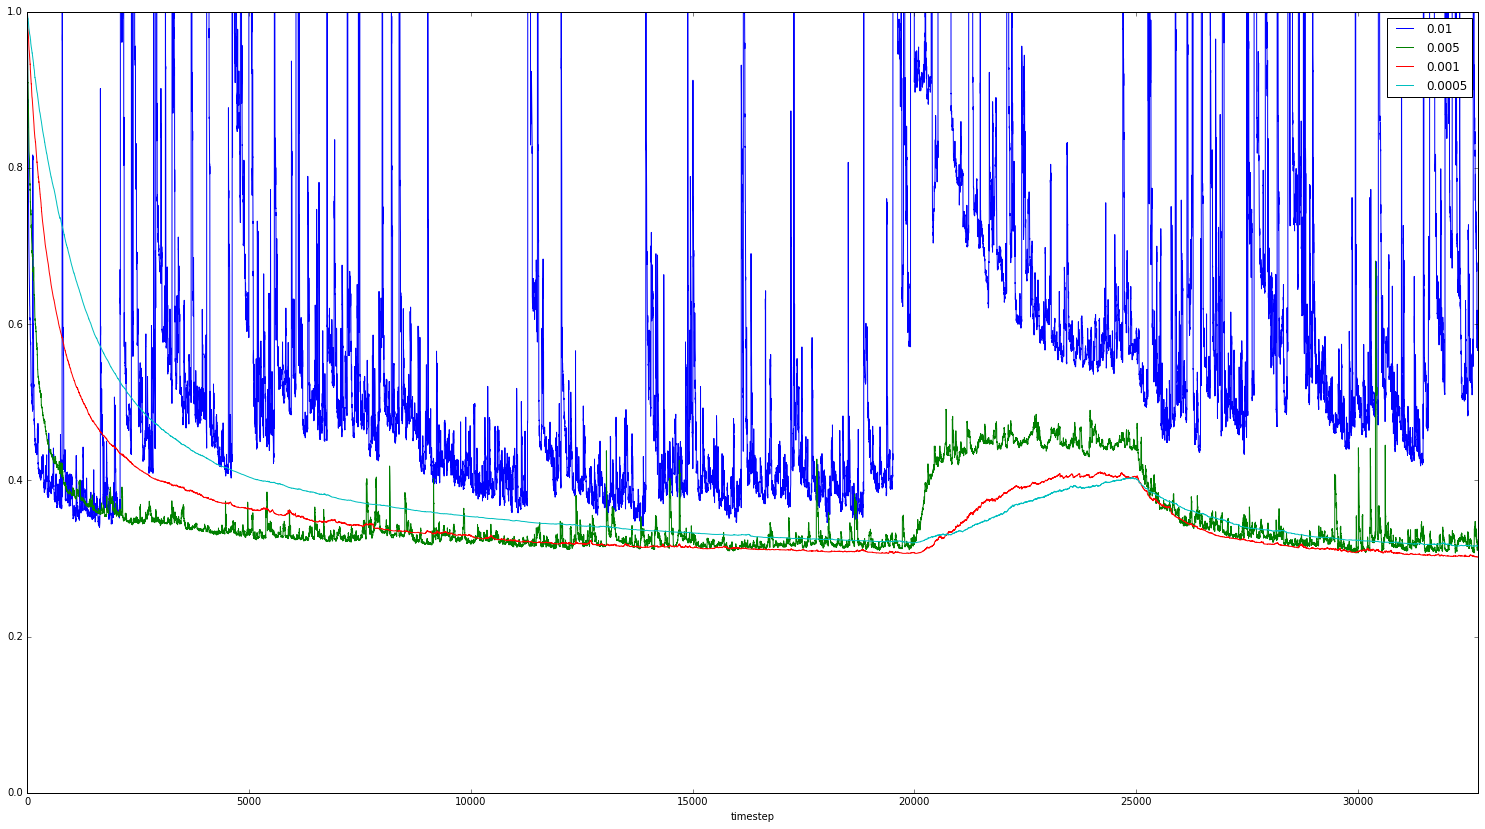

In [162]:
compare_learning_rates('adaline')